# Solving sparse equations with automatic differentiation
Suppose you wanted to solve the equations

$-2h_1+h_2+Q_1=0$

$h_1-2h_2+h_3+Q_2=0$

$h_2-2h_3+Q_3=0$

which are a 1D discretization of $\nabla h = Q$ with 3 nodes. You can describe the equations with this code:

In [1]:
import NonlinearEquations
import SparseArrays
@NonlinearEquations.equations function gw1d(h, Q)
    NonlinearEquations.setnumequations(3)#says there will be 3 equations that start out like 0=0
    NonlinearEquations.addterm(1, -2 * h[1])#add a term to the left hand side of the first equation
    NonlinearEquations.addterm(1, h[2] + Q[1])#add the rest of the first equation
    NonlinearEquations.addterm(2, h[1] - 2 * h[2] + h[3] + Q[2])#you can also add the whole equation at once
    if true
        NonlinearEquations.addterm(3, -2 * h[3] + h[2] + Q[3])#it's fine to include things like loops, if statements, etc. in the description of the equations
    end
end

gw1d_Q! (generic function with 1 method)

The `@NonlinearEquations.equations` macro transforms the above code into several functions. One of them is the residuals of the equations.

In [2]:
Q = ones(3)
gw1d_residuals(zeros(3), Q)

3-element Vector{Float64}:
 1.0
 1.0
 1.0

Another function computes a sparse version of the Jacobian of the equations with respect to `h`.

In [3]:
A = gw1d_h(zeros(3), Q)

3×3 SparseArrays.SparseMatrixCSC{Float64, Int64} with 7 stored entries:
 -2.0   1.0    ⋅ 
  1.0  -2.0   1.0
   ⋅    1.0  -2.0

These two functions can be combined to solve the equations.

In [4]:
h = A = gw1d_h(zeros(3), Q) \ -gw1d_residuals(zeros(3), Q)
gw1d_residuals(h, Q)

3-element Vector{Float64}:
 0.0
 0.0
 0.0

The macro also defined a function that can compute the Jacobian of the function with respect to Q.

In [5]:
gw1d_Q(h, Q)

3×3 SparseArrays.SparseMatrixCSC{Float64, Int64} with 3 stored entries:
 1.0   ⋅    ⋅ 
  ⋅   1.0   ⋅ 
  ⋅    ⋅   1.0

In general, it will construct a function to compute each of the Jacobians. With the Jacobians in hand, it is easy to tie into Julia's automatic differentiation ecosystem by defining new methods for `ChainRulesCore.rrule`.

# DPFEHM
[DPFEHM](https://github.com/OrchardLANL/DPFEHM.jl) is a subsurface flow and transport simulator implemented in Julia using these methods. DPFEHM uses the same numerical methods as EES-16's longstanding [FEHM](https://fehm.lanl.gov) code, so it is trustworthy. Using these automatic differentiation techniques means that DPFEHM integrates into Julia's automatic differentiation ecosystem.

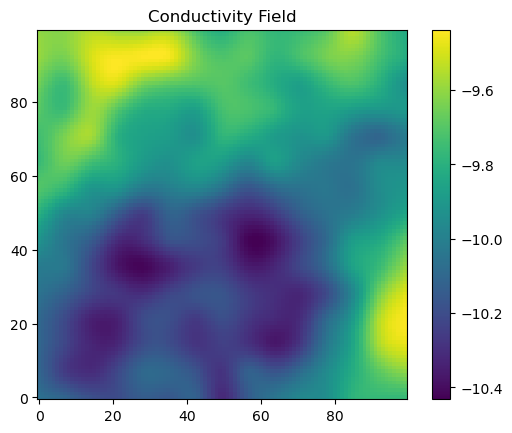


forward solve time

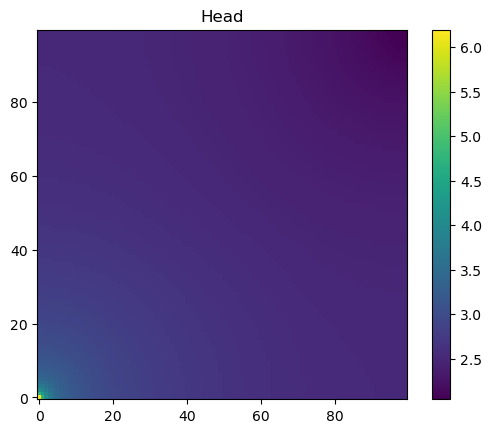

  2.275545 seconds (736.70 k allocations: 561.411 MiB, 3.58% gc time, 3.49% compilation time)

forward and gradient time  4.650734 seconds (2.32 M allocations: 1.169 GiB, 4.56% gc time, 7.48% compilation time)
gradient time  2.129318 seconds (883.49 k allocations: 574.720 MiB, 3.50% gc time, 0.38% compilation time)

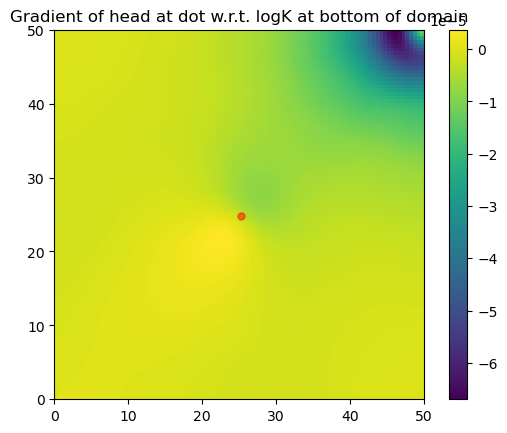

In [7]:
import DPFEHM
import GaussianRandomFields
import Optim
import PyPlot
import Random
import Zygote

Random.seed!(0)

#set up the grid
mins = [0, 0, 0]; maxs = [50, 50, 5]#size of the domain, in meters
ns = [100, 100, 10]#number of nodes on the grid
coords, neighbors, areasoverlengths, _ = DPFEHM.regulargrid3d(mins, maxs, ns)#build the grid

#set up the boundary conditions
Qs = zeros(size(coords, 2))
injectionnode = 1#inject in the lower left corner
Qs[injectionnode] = 1e-4#m^3/s
dirichletnodes = Int[size(coords, 2)]#fix the pressure in the upper right corner
dirichleths = zeros(size(coords, 2))
dirichleths[size(coords, 2)] = 0.0

#set up the conductivity field
lambda = 50.0#meters -- correlation length of log-conductivity
sigma = 1.0#standard deviation of log-conductivity
mu = -9.0#mean of log conductivity -- ~1e-4 m/s, like clean sand here https://en.wikipedia.org/wiki/Hydraulic_conductivity#/media/File:Groundwater_Freeze_and_Cherry_1979_Table_2-2.png
cov = GaussianRandomFields.CovarianceFunction(2, GaussianRandomFields.Matern(lambda, 1; σ=sigma))
x_pts = range(mins[1], maxs[1]; length=ns[1])
y_pts = range(mins[2], maxs[2]; length=ns[2])
num_eigenvectors = 200
grf = GaussianRandomFields.GaussianRandomField(cov, GaussianRandomFields.KarhunenLoeve(num_eigenvectors), x_pts, y_pts)
logKs = zeros(reverse(ns)...)
logKs2d = mu .+ GaussianRandomFields.sample(grf)'#generate a random realization of the log-conductivity field
for i = 1:ns[3]#copy the 2d field to each of the 3d layers
	v = view(logKs, i, :, :)
	v .= logKs2d
end

#plot the log-conductivity
fig, ax = PyPlot.subplots()
img = ax.imshow(logKs[1, :, :], origin="lower")
ax.title.set_text("Conductivity Field")
fig.colorbar(img)
display(fig)
println()
PyPlot.close(fig)

logKs2Ks_neighbors(Ks) = exp.(0.5 * (Ks[map(p->p[1], neighbors)] .+ Ks[map(p->p[2], neighbors)]))#convert from permeabilities at the nodes to permeabilities connecting the nodes
function solveforh(logKs, dirichleths)
	@assert length(logKs) == length(Qs)
	if maximum(logKs) - minimum(logKs) > 25
		return fill(NaN, length(Qs))#this is needed to prevent the solver from blowing up if the line search takes us somewhere crazy
	else
		Ks_neighbors = logKs2Ks_neighbors(logKs)
		return reshape(DPFEHM.groundwater_steadystate(Ks_neighbors, neighbors, areasoverlengths, dirichletnodes, dirichleths, Qs), reverse(ns)...)
	end
end

#now do a forward solve for the head
print("forward solve time")
@time hfree = solveforh(logKs, dirichleths)#solve for the head
isfreenode, nodei2freenodei, freenodei2nodei = DPFEHM.getfreenodes(length(dirichleths), dirichletnodes)
h = reshape(DPFEHM.addboundaryconditions(hfree, dirichletnodes, dirichleths, isfreenode, nodei2freenodei), reverse(ns)...)
#plot the head at the bottom of the domain
fig, ax = PyPlot.subplots()
img = ax.imshow(h[1, :, :], origin="lower")
ax.title.set_text("Head")
fig.colorbar(img)
display(fig)
println()
PyPlot.close(fig)

#now compute the gradient of a function involving solveforh
gradient_node = nodei2freenodei[div(size(coords, 2), 2) + 500]
gradient_node_x = coords[1, gradient_node]
gradient_node_y = coords[2, gradient_node]
print("forward and gradient time")
@time grad = Zygote.gradient((x, y)->solveforh(x, y)[gradient_node], logKs, dirichleths)#calculate the gradient (which involves a redundant calculation of the forward pass)
function_evaluation, back = Zygote.pullback((x, y)->solveforh(x, y)[gradient_node], logKs, dirichleths)#this pullback thing lets us not redo the forward pass
print("gradient time")
@time grad = back(1.0)#compute the gradient of a function involving solveforh
#plot the gradient of the function w.r.t. the logK at the bottom of the domain
fig, ax = PyPlot.subplots()
img = ax.imshow(grad[1][1, :, :], origin="lower", extent=[mins[1], maxs[1], mins[2], maxs[2]])
ax.plot([gradient_node_x], [gradient_node_y], "r.", ms=10, alpha=0.5)
ax.title.set_text("Gradient of head at dot w.r.t. logK at bottom of domain")
fig.colorbar(img)
display(fig)
println()
PyPlot.close(fig)

### Inverse analysis with automatic differentiation

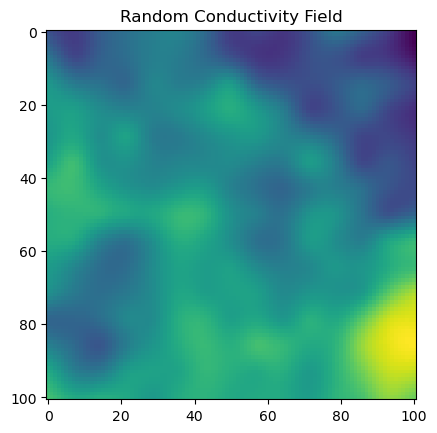

  0.897031 seconds (2.32 M allocations: 119.958 MiB, 21.13% gc time)
  0.005413 seconds (19 allocations: 15.802 MiB)


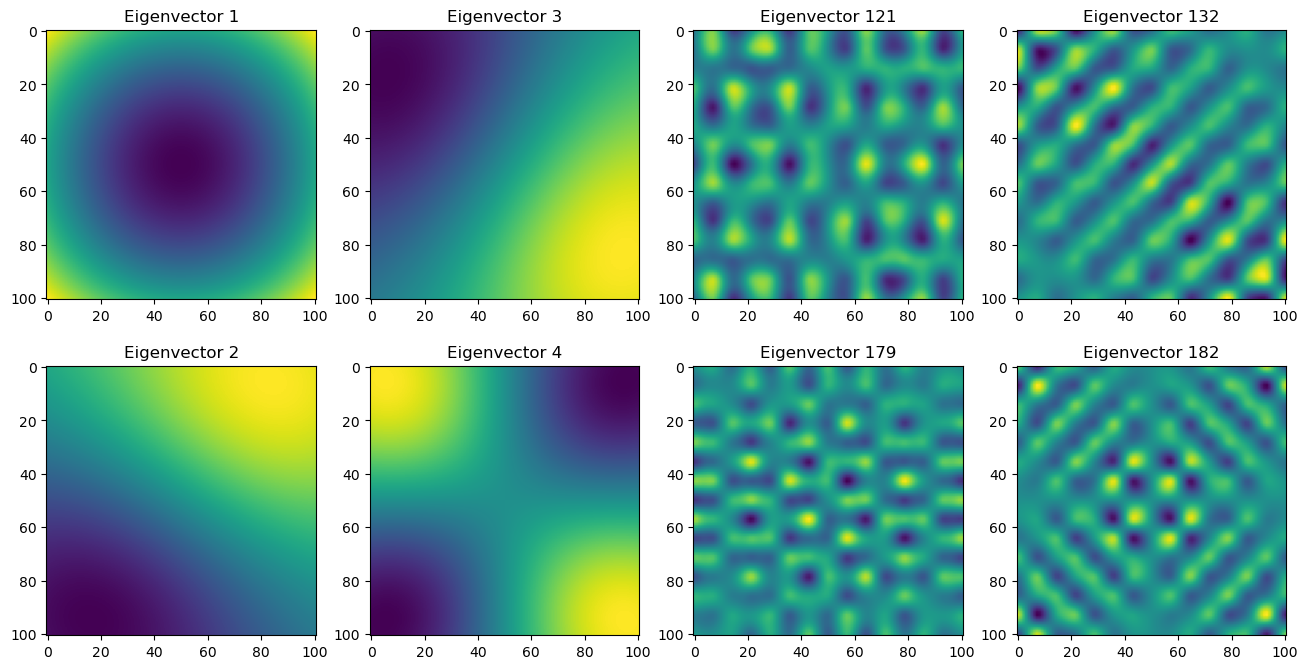



forward solve time  0.024820 seconds (41.07 k allocations: 35.050 MiB)
gradient time  0.051690 seconds (102.63 k allocations: 72.659 MiB)
eigs forward solve time  0.157930 seconds (293.74 k allocations: 50.485 MiB, 15.86% gc time, 67.90% compilation time)
eigs gradient time

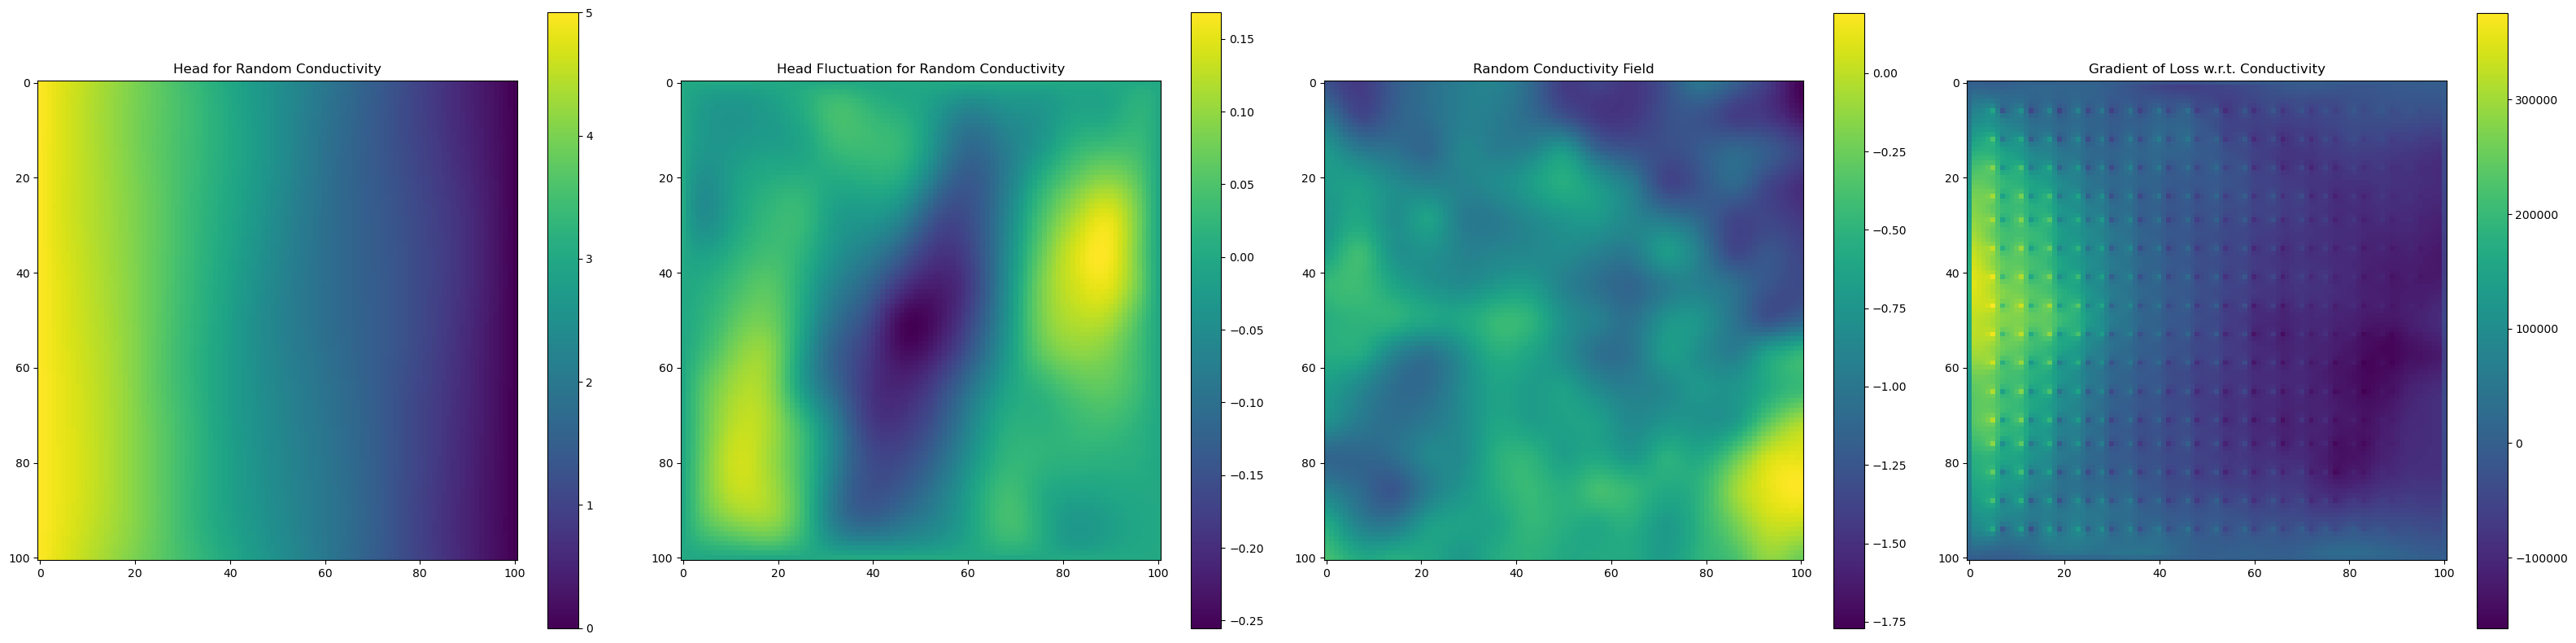

  0.066974 seconds (102.73 k allocations: 88.292 MiB, 25.58% gc time)


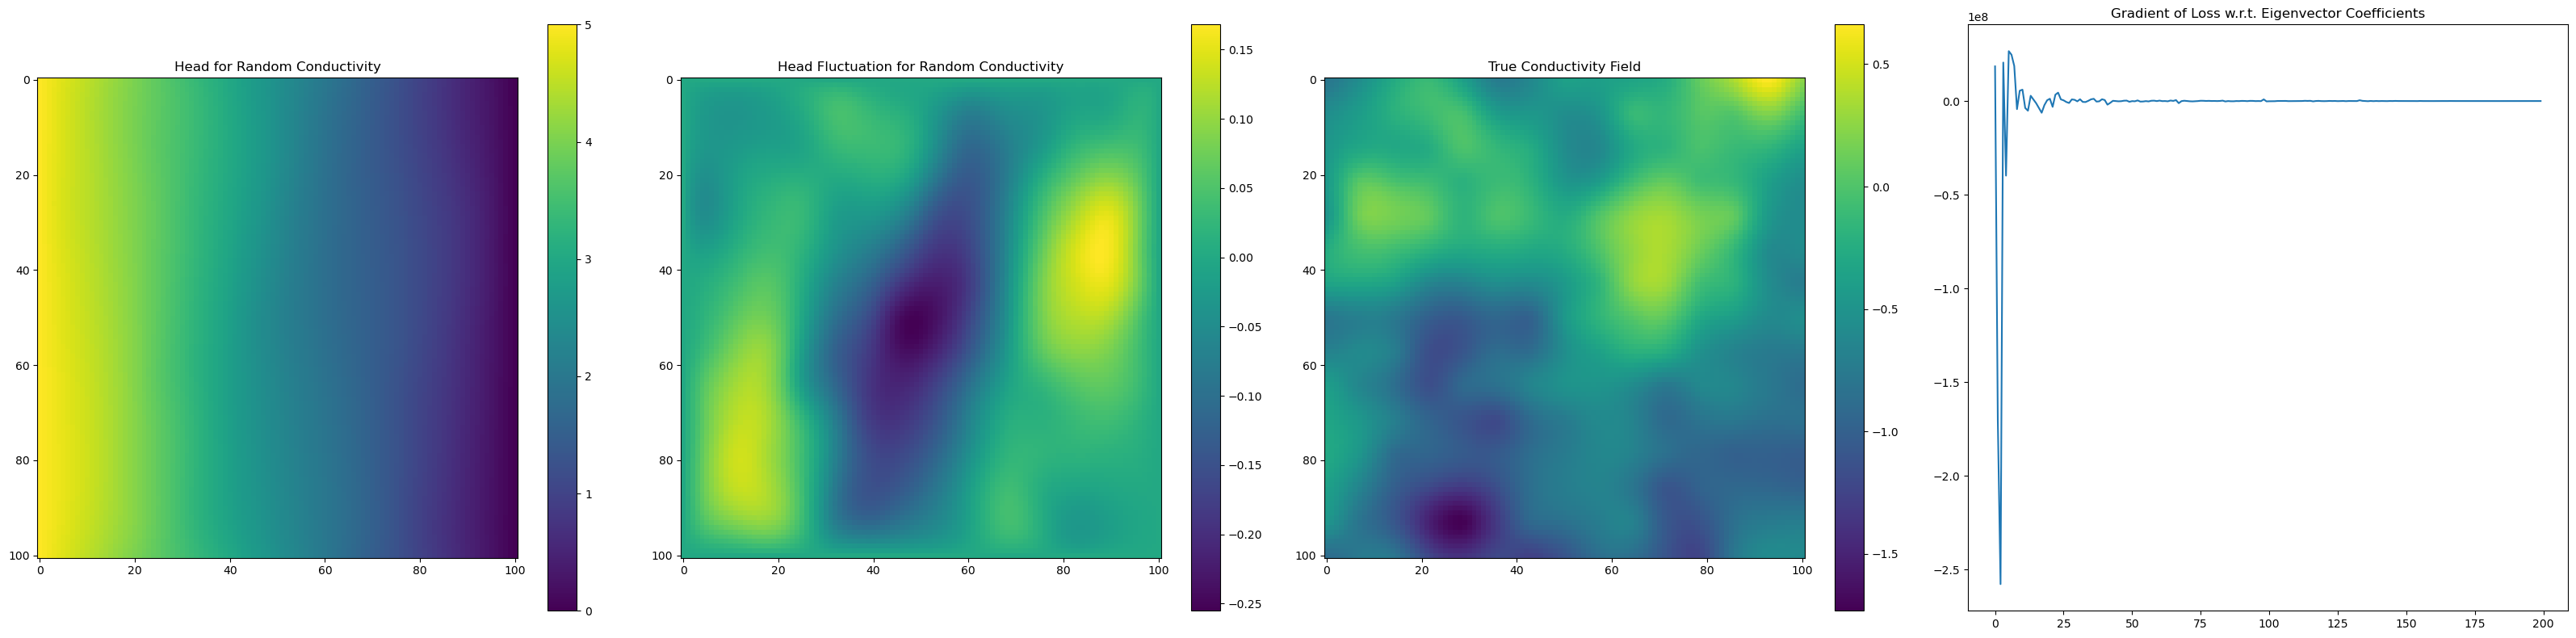



  0.803073 seconds (2.32 M allocations: 119.958 MiB, 2.83% gc time)
  0.005816 seconds (19 allocations: 15.802 MiB)
forward solve time  0.024688 seconds (41.07 k allocations: 35.050 MiB)
gradient time  0.059541 seconds (102.63 k allocations: 72.659 MiB, 17.27% gc time)
eigs forward solve time  0.023013 seconds (41.09 k allocations: 35.138 MiB)
eigs gradient time  0.060827 seconds (102.73 k allocations: 88.292 MiB, 34.45% gc time)
Optimization timeIter     Function value   Gradient norm 
     0     2.189433e+06     4.807763e+06
 * time: 0.017802000045776367
     1     1.674815e+06     8.950371e+05
 * time: 2.260662078857422
     2     6.337174e+05     1.032642e+06
 * time: 2.7143020629882812
     3     3.876957e+05     1.769247e+05
 * time: 2.90493106842041
     4     3.490743e+05     4.879957e+05
 * time: 3.2488739490509033
     5     2.803194e+05     3.453113e+05
 * time: 3.5348379611968994
     6     1.145470e+05     6.872293e+05
 * time: 3.8767330646514893
     7     9.335480e+04 

   113     2.723395e+03     1.245959e+04
 * time: 33.27468991279602
   114     2.707264e+03     2.647672e+03
 * time: 33.54075288772583
   115     2.696262e+03     3.986684e+03
 * time: 33.89580011367798
   116     2.569354e+03     4.045392e+03
 * time: 34.16026496887207
   117     2.514132e+03     1.509616e+04
 * time: 34.34610104560852
   118     2.479960e+03     5.225051e+03
 * time: 34.5270779132843
   119     2.434015e+03     5.593011e+03
 * time: 34.88641405105591
   120     2.423000e+03     2.355264e+03
 * time: 35.07976698875427
   121     2.408025e+03     3.039690e+03
 * time: 35.36594200134277
   122     2.373073e+03     5.464738e+03
 * time: 35.64740800857544
   123     2.368532e+03     3.617462e+03
 * time: 35.85651206970215
   124     2.366375e+03     2.076870e+03
 * time: 36.131999015808105
   125     2.362531e+03     3.883418e+03
 * time: 36.41177201271057
   126     2.355180e+03     1.896987e+03
 * time: 36.699816942214966
   127     2.340689e+03     2.022000e+03
 * tim

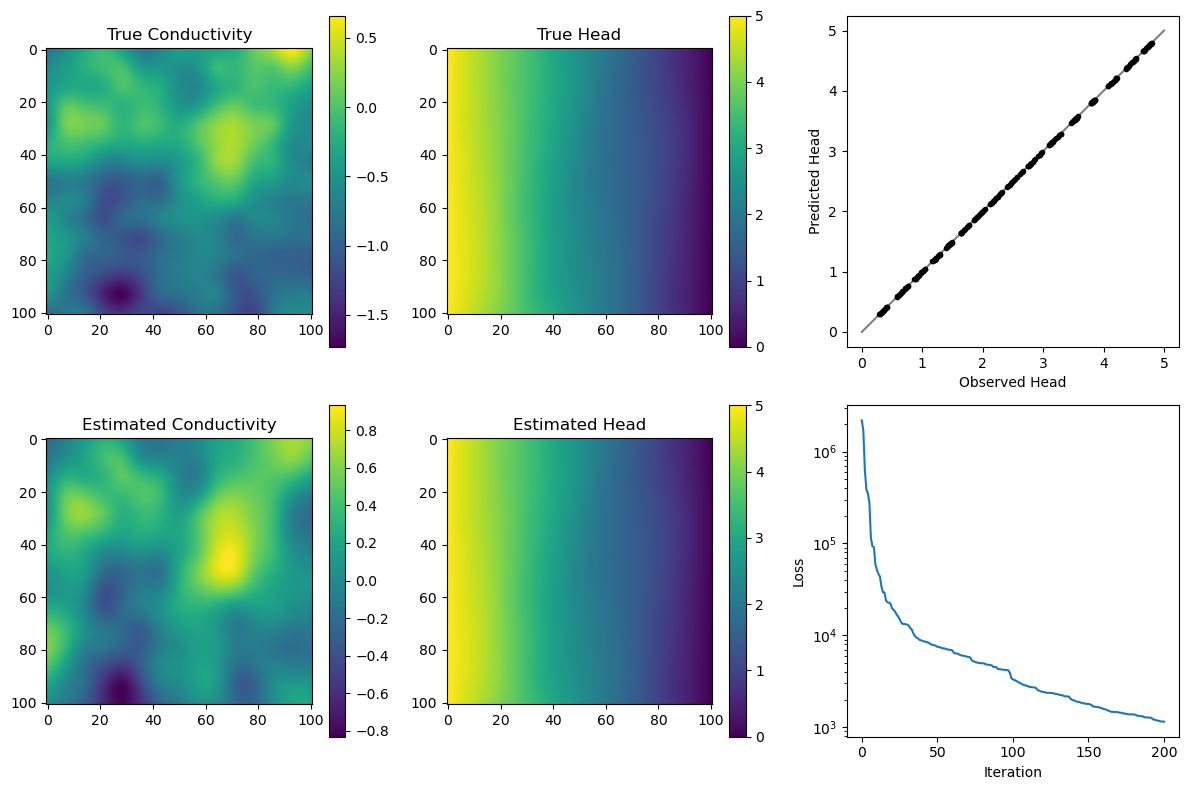

 60.059957 seconds (100.95 M allocations: 73.922 GiB, 15.81% gc time, 5.13% compilation time)



In [8]:
import DPFEHM
import GaussianRandomFields
import Optim
import PyPlot
import Random
import Zygote

Random.seed!(0)

function getobsnodes(coords, obslocs)
	obsnodes = Array{Int}(undef, length(obslocs))
	for i = 1:length(obslocs)
		obsnodes[i] = findmin(map(j->sum((obslocs[i] .- coords[:, j]) .^ 2), 1:size(coords, 2)))[2]
	end
	return obsnodes
end

mins = [0, 0]#meters
maxs = [100, 100]#meters
allns = [[101, 101]]
allns = [[allns[end]]; allns]
num_eigenvectors = 200
x_true = randn(num_eigenvectors)
x0 = zeros(num_eigenvectors)
sqrtnumobs = 16
obslocs_x = range(mins[1], maxs[1]; length=sqrtnumobs + 2)[2:end - 1]
obslocs_y = range(mins[2], maxs[2]; length=sqrtnumobs + 2)[2:end - 1]
obslocs = collect(Iterators.product(obslocs_x, obslocs_y))[:]
observations = Array{Float64}(undef, length(obslocs))
for (i, ns) in enumerate(allns)
	Random.seed!(0)
	global x_true
	global x0
	global observations
	coords, neighbors, areasoverlengths, _ = DPFEHM.regulargrid2d(mins, maxs, ns, 1.0)
	Qs = zeros(size(coords, 2))
	boundaryhead(x, y) = 5 * (x - maxs[1]) / (mins[1] - maxs[1])
	dirichletnodes = Int[]
	dirichleths = zeros(size(coords, 2))
	for i = 1:size(coords, 2)
		if coords[1, i] == mins[1] || coords[1, i] == maxs[1] || coords[2, i] == mins[2] || coords[2, i] == maxs[2]
			push!(dirichletnodes, i)
			dirichleths[i] = boundaryhead(coords[1:2, i]...)
		end
	end

	lambda = 50.0#meters -- correlation length of log-conductivity
	sigma = 1.0#standard deviation of log-conductivity
	mu = 0.0#mean of log-permeability can be arbitrary because this is steady-state and there are no fluid sources

	cov = GaussianRandomFields.CovarianceFunction(2, GaussianRandomFields.Matern(lambda, 1; σ=sigma))
	x_pts = range(mins[1], maxs[1]; length=ns[1])
	y_pts = range(mins[2], maxs[2]; length=ns[2])
	@time grf = GaussianRandomFields.GaussianRandomField(cov, GaussianRandomFields.KarhunenLoeve(num_eigenvectors), x_pts, y_pts)
	@time logKs = GaussianRandomFields.sample(grf)
	parameterization = copy(grf.data.eigenfunc)
	sigmas = copy(grf.data.eigenval)

	if i == 1#only plot this the first time around
		#plot a realization
		fig, ax = PyPlot.subplots()
		ax.imshow(logKs)
		ax.title.set_text("Random Conductivity Field")
		display(fig)
		println()
		PyPlot.close(fig)

		#plot the first few eigenvectors and some random ones
		fig, axs = PyPlot.subplots(2, 4, figsize=(16, 8))
		rp = Random.randperm(size(parameterization, 2))
		for (i, ax) in enumerate(axs)
			if i <= length(axs) / 2
				ax.imshow(reshape(parameterization[:, i], ns...))
				ax.title.set_text("Eigenvector $i")
			else
				ax.imshow(reshape(parameterization[:, rp[i]], ns...))
				ax.title.set_text("Eigenvector $(rp[i])")
			end
		end
		display(fig)
		println()
		PyPlot.close(fig)
	end

	#logKs2Ks_neighbors(Ks) = map(neighbor->exp(0.5 * (Ks[neighbor[1]] + Ks[neighbor[2]])), neighbors)
	#logKs2Ks_neighbors(Ks) = exp.([0.5 * (Ks[i1] + Ks[i2]) for (i1, i2) in neighbors])
	logKs2Ks_neighbors(Ks) = exp.(0.5 * (Ks[map(p->p[1], neighbors)] .+ Ks[map(p->p[2], neighbors)]))#Zygote differentiates this efficiently but the definitions above are ineffecient with Zygote
	function solveforh(logKs, dirichleths)
		@assert length(logKs) == length(Qs)
		if maximum(logKs) - minimum(logKs) > 25
			return fill(NaN, length(Qs))#this is needed to prevent the solver from blowing up if the line search takes us somewhere crazy
		else
			Ks_neighbors = logKs2Ks_neighbors(logKs)
			return DPFEHM.groundwater_steadystate(Ks_neighbors, neighbors, areasoverlengths, dirichletnodes, dirichleths, Qs)
		end
	end
	solveforheigs(x) = solveforh(x2logKs(x), dirichleths)
	x2logKs(x) = reshape(parameterization * (sigmas .* x), ns...)
	logKs_true = x2logKs(x_true)
	h_true = solveforheigs(x_true)

	numobs = 250
	obsnodes = getobsnodes(coords, obslocs)
	obssigma = 1e-3
	f(logKs) = sum((solveforh(logKs, dirichleths)[obsnodes] - observations) .^ 2 ./ obssigma ^ 2)
	h = solveforh(logKs, dirichleths)
	h = solveforh(logKs, dirichleths)
	print("forward solve time")
	@time h = solveforh(logKs_true, dirichleths)
	zg = Zygote.gradient(f, logKs)[1]
	zg = Zygote.gradient(f, logKs)[1]#work out the precompilation
	print("gradient time")
	@time zg = Zygote.gradient(f, logKs)[1]

	#now reformulate the function in terms of the cofficients of the eigenvectors with some regularization in there
	feigs(x) = f(x2logKs(x)) + sum(x .^ 2)
	print("eigs forward solve time")
	@time feigs(x_true)
	zgeigs = Zygote.gradient(feigs, x_true)[1]
	print("eigs gradient time")
	@time zgeigs = Zygote.gradient(feigs, x_true)[1]

	if i == 1#first time around plot a bunch of stuff and set up the observations
		#plot the solution, the difference between the solution and the solution for a uniform medium, and the logKs
		fig, axs = PyPlot.subplots(1, 4, figsize=(32, 8))
		ims = axs[1].imshow(reshape(h, ns...))
		axs[1].title.set_text("Head for Random Conductivity")
		fig.colorbar(ims, ax=axs[1])
		ims = axs[2].imshow(reshape(h .- map(i->boundaryhead(coords[:, i]...), 1:size(coords, 2)), ns...))
		axs[2].title.set_text("Head Fluctuation for Random Conductivity")
		fig.colorbar(ims, ax=axs[2])
		ims = axs[3].imshow(logKs)
		axs[3].title.set_text("Random Conductivity Field")
		fig.colorbar(ims, ax=axs[3])
		ims = axs[4].imshow(zg)
		axs[4].title.set_text("Gradient of Loss w.r.t. Conductivity")
		fig.colorbar(ims, ax=axs[4])
		fig.tight_layout()
		display(fig)
		println()
		PyPlot.close(fig)

		#plot the solution, the difference between the solution and the solution for a uniform medium, and the logKs
		fig, axs = PyPlot.subplots(1, 4, figsize=(32, 8))
		ims = axs[1].imshow(reshape(h_true, ns...))
		axs[1].title.set_text("Head for Random Conductivity")
		fig.colorbar(ims, ax=axs[1])
		ims = axs[2].imshow(reshape(h_true .- map(i->boundaryhead(coords[:, i]...), 1:size(coords, 2)), ns...))
		axs[2].title.set_text("Head Fluctuation for Random Conductivity")
		fig.colorbar(ims, ax=axs[2])
		ims = axs[3].imshow(x2logKs(x_true))
		axs[3].title.set_text("True Conductivity Field")
		fig.colorbar(ims, ax=axs[3])
		ims = axs[4].plot(zgeigs)
		axs[4].title.set_text("Gradient of Loss w.r.t. Eigenvector Coefficients")
		fig.tight_layout()
		display(fig)
		println()
		PyPlot.close(fig)

		observations .= h_true[obsnodes]#set up the observations
	else#otherwise, do the optimization
		options = Optim.Options(iterations=200, extended_trace=false, store_trace=true, show_trace=ifelse(i == length(allns), true, false), x_tol=1e-6, time_limit=60 * 60 * 2)
		print("Optimization time")
		@time opt = Optim.optimize(feigs, x->Zygote.gradient(feigs, x)[1], x0, Optim.LBFGS(), options; inplace=false)
		#@time opt = Optim.optimize(feigs, x->Zygote.gradient(feigs, x)[1], x0, Optim.GradientDescent(), options; inplace=false)
		x_est = opt.minimizer
		logKs_est = x2logKs(x_est)

		#plot results from the inverse analysis
		fig, axs = PyPlot.subplots(2, 3, figsize=(12, 8))
		ims = axs[1].imshow(logKs_true)
		axs[1].title.set_text("True Conductivity")
		fig.colorbar(ims, ax=axs[1])
		ims = axs[2].imshow(logKs_est)
		axs[2].title.set_text("Estimated Conductivity")
		fig.colorbar(ims, ax=axs[2])
		ims = axs[3].imshow(reshape(solveforh(logKs_true, dirichleths), ns...))
		axs[3].title.set_text("True Head")
		#ims = axs[3].imshow(x2logKs(x0))
		#axs[3].title.set_text("Previous Conductivity Estimate")
		fig.colorbar(ims, ax=axs[3])
		#ims = axs[4].imshow(logKs_est - x2logKs(x0))
		#axs[4].title.set_text("Conductivity Update")
		ims = axs[4].imshow(reshape(solveforh(logKs_est, dirichleths), ns...))
		axs[4].title.set_text("Estimated Head")
		fig.colorbar(ims, ax=axs[4])
		axs[5].plot([0, 5], [0, 5], "k", alpha=0.5)
		axs[5].plot(observations, solveforh(logKs_est, dirichleths)[obsnodes], "k.")
		axs[5].set_xlabel("Observed Head")
		axs[5].set_ylabel("Predicted Head")
		axs[6].semilogy(map(i->opt.trace[i].value, 1:length(opt.trace)))
		axs[6].set_xlabel("Iteration")
		axs[6].set_ylabel("Loss")
		fig.tight_layout()
		#fig.savefig("figs/level_$(i - 1).pdf")
		display(fig)
		println()
		PyPlot.close(fig)

		x0 = x_est#update x0 for the next optimization
	end
end

### Training a convolutional neural network with a physics model in the loss function

It's easy because the neural network and the physics model work with the same automatic differentiation system.

epoch: 0 train rmse: 1.0160952672696897 test rmse: 1.0152164053577868
epoch: 1 time: 8.505385461 train rmse: 0.2780683230085087 test rmse: 0.2542641260123571
epoch: 2 time: 5.227360102 train rmse: 0.1968828454454943 test rmse: 0.18637642602290286
epoch: 3 time: 5.039715208 train rmse: 0.19081204491651718 test rmse: 0.195586144931621
epoch: 4 time: 5.193131956 train rmse: 0.16449357164096198 test rmse: 0.19242336472797966
epoch: 5 time: 5.373138927 train rmse: 0.17545056115190374 test rmse: 0.18546021603075838
epoch: 6 time: 5.49247282 train rmse: 0.19253463314189667 test rmse: 0.2185356792707845
epoch: 7 time: 5.400173671 train rmse: 0.17986606720499956 test rmse: 0.19573350339367107
epoch: 8 time: 5.201342537 train rmse: 0.18445561995703447 test rmse: 0.19290465643586724
epoch: 9 time: 5.266227298 train rmse: 0.15134758023146025 test rmse: 0.16591435941760047


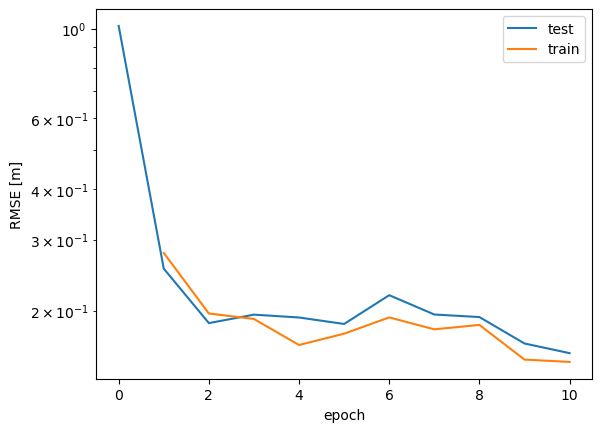

epoch: 10 time: 5.296087595 train rmse: 0.1493550255430235 test rmse: 0.15701942690428974
The training has finished!


In [20]:
import DPFEHM
import GaussianRandomFields
import Optim
import Random
import Zygote

using JLD2
using Statistics: mean, std

global losses_train = Float64[]
global losses_test = Float64[]
global rmses_train = Float64[]
global rmses_test = Float64[]
global train_time = Float64[]

#@everywhere begin
    using Flux
    using Random
    using GaussianRandomFields
    using DPFEHM

    n = 51
    ns = [n, n]
    steadyhead = 0e0
    sidelength = 200
    thickness  = 1.0
    mins = [-sidelength, -sidelength] #meters
    maxs = [sidelength, sidelength] #meters
    num_eigenvectors = 200
    sigma = 1.0
    lambda = 50
    cov = GaussianRandomFields.CovarianceFunction(2, GaussianRandomFields.Matern(lambda, 1; σ=sigma))
    x_pts = range(mins[1], maxs[1]; length=ns[1])
    y_pts = range(mins[2], maxs[2]; length=ns[2])
    grf = GaussianRandomFields.GaussianRandomField(cov, GaussianRandomFields.KarhunenLoeve(num_eigenvectors), x_pts, y_pts)

    pressure_target  = 1.0

    coords, neighbors, areasoverlengths, volumes = DPFEHM.regulargrid2d(mins, maxs, ns, thickness)
    dirichletnodes = Int[]
    dirichleths = zeros(size(coords, 2))
    for i = 1:size(coords, 2)
        if abs(coords[1, i]) == sidelength || abs(coords[2, i]) == sidelength
            push!(dirichletnodes, i)
            dirichleths[i] = steadyhead
        end
    end

    function getQs(Qs::Vector, is::Vector)
        sum(Qs .* ((collect(1:size(coords, 2)) .== i) for i in is))
    end

    function solve_numerical(Qs, T)
        logKs2Ks_neighbors(Ks) = exp.(0.5 * (Ks[map(p->p[1], neighbors)] .+ Ks[map(p->p[2], neighbors)]))
        Qs = getQs(Qs, injection_extraction_nodes)
        @assert length(T) == length(Qs)
        Ks_neighbors = logKs2Ks_neighbors(T)
        h_gw = DPFEHM.groundwater_steadystate(Ks_neighbors, neighbors, areasoverlengths, dirichletnodes, dirichleths, Qs)
        @assert coords[:, monitoring_well_node] == [-80, -80]#make sure we are looking at the right node
        return h_gw[monitoring_well_node] - steadyhead
    end
#end

#like LeNet5
model = Chain(Conv((5, 5), 1=>6, relu),
              MaxPool((2, 2)),
              Conv((5, 5), 6=>16, relu),
              MaxPool((2, 2)),
              flatten,
              Dense(1296, 120, relu),
              Dense(120, 84, relu),
              Dense(84, 1)) |> f64

# Make neural network parameters trackable by Flux
θ = params(model)

function loss(x)
    Ts = reshape(hcat(map(y->y[1], x)...), size(x[1][1], 1), size(x[1][1], 2), 1, length(x))
    targets = map(y->y[2], x)
    #@show size(Ts)
    Q1 = model(Ts)
    Qs = map(Q->[Q, Qinj], Q1)
    loss = sum(map(i->solve_numerical(Qs[i], Ts[:, :, 1, i]) - targets[i], 1:size(Ts, 4)).^2)
    return loss
end

opt = ADAM()

# Injection rate
Qinj = 0.031688 # [m^3/s] (1 MMT water/yr)
# Training epochs
epochs = 1:10
# Calculate distance between extraction and injection wells
monitoring_well_node = 781
@assert coords[:, monitoring_well_node] == [-80, -80]
injection_extraction_nodes = [1041, 1821]
@assert coords[:, injection_extraction_nodes[1]] == [-40, -40]
@assert coords[:, injection_extraction_nodes[2]] == [80, 80]

# batch 1:1 for one batch size
batch_size = 16
data_train_batch = [[(GaussianRandomFields.sample(grf), pressure_target) for i = 1:batch_size] for v in 1:16]
data_test = [[(GaussianRandomFields.sample(grf), pressure_target) for i = 1:batch_size] for v in 1:8]

loss_train = sum(map(x->loss(x), data_train_batch))
rmse_train = sqrt(loss_train/(batch_size*length(data_train_batch)))
loss_test = sum(map(x->loss(x), data_test))
rmse_test = sqrt(loss_test/(batch_size * length(data_test)))
println(string("epoch: 0 train rmse: ", rmse_train, " test rmse: ", rmse_test))
# Save convergence metrics
push!(losses_test, loss_test)
push!(rmses_test, rmse_test)
for epoch in epochs
    data_train_batch = [[(GaussianRandomFields.sample(grf), pressure_target) for i = 1:batch_size] for v in 1:16]
    tt = @elapsed Flux.train!(loss, θ, data_train_batch, opt)
    push!(train_time, tt)
    loss_train = sum(map(x->loss(x), data_train_batch))
    rmse_train = sqrt(loss_train/(batch_size*length(data_train_batch)))
    loss_test = sum(map(x->loss(x), data_test))
    rmse_test = sqrt(loss_test/(batch_size * length(data_test)))
    # Terminal output
    println(string("epoch: ", epoch, " time: ", tt, " train rmse: ", rmse_train, " test rmse: ", rmse_test))
    # Save convergence metrics
    push!(losses_train, loss_train)
    push!(rmses_train, rmse_train)
    push!(losses_test, loss_test)
    push!(rmses_test, rmse_test)
end
println("The training has finished!")

fig, ax = PyPlot.subplots()
ax.semilogy(0:length(rmses_train), rmses_test, label="test")
ax.semilogy(1:length(rmses_train), rmses_train, label="train")
ax.set(xlabel="epoch", ylabel="RMSE [m]")
ax.legend()
display(fig)
PyPlot.close(fig)